# Exercise 3 - Modeling and Evaluation

You should have completed exercises 1 and 2 before this exercise. We use the same dataset "train_FD001.txt" as in the first two exercises. Additionally, a test set "test_FD001.txt" and the test set labels "RUL_FD001.txt" are available on moodle.

The focus of this task lies on developing a machine learning model to estimate the remaining useful lifetime of aircraft engines. For the application of predictive maintenance, a very important task is to decide whether the aircraft engine is still in a healthy condition or if there are already signs of degradation and the remaining useful lifetime is already close to zero. To prevent failure and apply maintenance measures in time, you want to build a classifier that classifies the aircraft engines in healthy and faulty engines. For safety reasons, engines are defined as faulty, when their remaining useful lifetime is less than 30 cycles.

To perform the classification task, a decision tree algorithm shall be used. Decision trees work by splitting the available data into subsets using a series of rule-based criteria. The topic of decision trees will also be covered more extensively in Lecture VIII.

## Datasets
In Moodle, you can download the files “train_FD001.txt”, “test_FD001.txt” and “RUL_FD001.txt”. “Train_FD001” contains run-to-failure curves from several engines. The dataset contains in total 26 parameters that are shown in Table 1.
For each data entry, the corresponding engine number and cycle number is given. All engines were simulated until failure, meaning that the cycle numbers reach from 1 to the end of life of the engines. Parameters 2 - 4 indicate the operating conditions that were input parameters for the simulation. The remaining parameters 5 - 25 are the simulated sensor data and therefore the output of the simulation.

“Test_FD001” contains measurements of 100 engines. The parameters (operating conditions and sensor data) are the same as in the “train_FD001” file. However, the test set does not contain run-to-failure curves. The given cycles are only a section of the total operating time of the engines and do not end with a RUL of 0. Therefore, the “RUL_FD001” file provides the RUL at the last given cycle for each of the engines in the test set.

First, we load basic libraries.

In [26]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

### 1. Load the training data, rename columns if you wish to. Calculate the remaining useful lifetime (RUL) of the aircraft engines and append it to the dataframe. (Repetition from the first exercises)

In [29]:
df_train = pd.read_csv("train_FD001.txt", sep=" ", header=None)
df_train = df_train.drop(columns=[26,27])
data_header = {0: 'Engine', 1: 'Cycle', 2: 'Altitude', 3: 'MachNumber', 4: 'TRA', 5: 'T2', 6: 'T24', 7: 'T30', 8: 'T50', 9: 'P2', 10: 'P15', 11: 'P30', 12: 'Nf', 13: 'Nc', 14: 'epr', 15: 'Ps30', 16: 'phi', 17: 'NRf',
               18: 'NRc', 19: 'BPR', 20: 'farB', 21: 'htBleed', 22: 'Nf_dmd', 23: 'PCNfR_dmd', 24: 'W31', 25: 'W32'}
df_train = df_train.rename(columns=data_header)

df_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 20631 entries, 0 to 20630
Data columns (total 26 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   Engine      20631 non-null  int64  
 1   Cycle       20631 non-null  int64  
 2   Altitude    20631 non-null  float64
 3   MachNumber  20631 non-null  float64
 4   TRA         20631 non-null  float64
 5   T2          20631 non-null  float64
 6   T24         20631 non-null  float64
 7   T30         20631 non-null  float64
 8   T50         20631 non-null  float64
 9   P2          20631 non-null  float64
 10  P15         20631 non-null  float64
 11  P30         20631 non-null  float64
 12  Nf          20631 non-null  float64
 13  Nc          20631 non-null  float64
 14  epr         20631 non-null  float64
 15  Ps30        20631 non-null  float64
 16  phi         20631 non-null  float64
 17  NRf         20631 non-null  float64
 18  NRc         20631 non-null  float64
 19  BPR         20631 non-nul

Just to remember the meaning of the data:

| Parameter | Name       | Description                      | Units    |
|-----------|------------|----------------------------------|----------|
| 0     	   | Engine     | 	Engine number                   | 	-       |
| 1	        | Cycle	     | Cycle number                     | 	-       |
| 2	        | Altitude   | 	Altitude                        | 	1000 ft |
| 3	        | MachNumber | 	Mach Number                     | 	-       |
| 4	        | TRA        | 	Thrust Resolver Angle           | 	-       |
| 5	        | T2         | 	Total temperature at fan inlet  | 	°R      |
| 6	        | T24        | 	Total temperature at LPC outlet | 	°R      |
| 7	        | T30        | 	Total temperature at HPC outlet | 	°R      |
| 8	        | T50        | 	Total temperature at LPT outlet | 	°R      |
| 9	        | P2         | 	Pressure at fan inlet           | 	psia    |
| 10	       | P15        | 	Total pressure in bypass-duct   | 	psia    |
| 11	       | P30        | 	Total pressure at HPC outlet    | 	psia    |
| 12	       | Nf         | 	Physical fan speed              | 	rpm     |
| 13	       | Nc         | 	Physical core speed             | 	rpm     |
| 14	       | epr        | 	Engine pressure ratio           | 	-       |
| 15	       | Ps30       | 	Static pressure at HPC outlet   | 	psia    |
| 16	       | phi        | 	Ratio of fuel flow to Ps30      | 	pps/psi |
| 17	       | NRf        | 	Corrected fan speed             | 	rpm     |
| 18	       | NRc        | 	Corrected core speed            | 	rpm     |
| 19	       | BPR        | 	Bypass ratio                    | 	-       |
| 20	       | farB       | 	Burner fuel-air ratio           | 	-       |
| 21	       | htBleed    | 	Bleed enthalpy                  | 	-       |
| 22	       | Nf_dmd     | 	Demanded fan speed              | 	rpm     |
| 23	       | PCNfR_dmd  | 	Demanded corrected fan speed    | 	rpm     |
| 24	       | W31        | 	HPT coolant bleed               | 	lbm/s   |
| 25	       | W32        | 	LPT coolant bleed               | 	lpm/s   |

In [19]:
# calculate maximum cycles per engine
df_max_cycles = df_train[['Engine', 'Cycle']].groupby(['Engine']).max()
df_max_cycles = df_max_cycles.rename(columns={'Cycle': 'Max_Cycles'})

# merge the max_cycles value to the dataframe
df_train = df_train.merge(df_max_cycles, left_on='Engine', right_index=True)

# calculation of remaining useful life
df_train['RUL'] = df_train['Max_Cycles'] - df_train['Cycle']

### 2. Load and inspect the test data set. The test data set contains measurements of aircraft engines over a certain amount of cycles. However, these measurements are not run-to-failure curves and only an excerpt of the total lifetime of the engines.

In [39]:
df_test = pd.read_csv("test_FD001.txt", sep=" ", header=None)
df_test = df_test.drop(columns=[26, 27])
df_test = df_test.rename(columns=data_header)

,Engine,Cycle,Altitude,MachNumber,TRA,T2,T24,T30,T50,P2,...,phi,NRf,NRc,BPR,farB,htBleed,Nf_dmd,PCNfR_dmd,W31,W32
count,13096.000000,13096.000000,13096.000000,13096.000000,13096.0,13096.00,13096.000000,13096.000000,13096.000000,1.309600e+04,...,13096.000000,13096.000000,13096.000000,13096.000000,1.309600e+04,13096.000000,13096.0,13096.0,13096.000000,13096.000000
mean,51.543907,76.836515,-0.000011,0.000004,100.0,518.67,642.475088,1588.099204,1404.735362,1.462000e+01,...,521.747724,2388.071025,8138.947817,8.425844,3.000000e-02,392.571625,2388.0,100.0,38.892502,23.335743
std,28.289423,53.057749,0.002203,0.000294,0.0,0.00,0.400899,5.003274,6.688309,1.776425e-15,...,0.559627,0.056934,10.188605,0.029009,1.040874e-17,1.233577,0.0,0.0,0.141681,0.084120
min,1.000000,1.000000,-0.008200,-0.000600,100.0,518.67,641.130000,1569.040000,1384.390000,1.462000e+01,...,519.380000,2387.890000,8108.500000,8.332800,3.000000e-02,389.000000,2388.0,100.0,38.310000,22.935400
25%,28.000000,33.000000,-0.001500,-0.000200,100.0,518.67,642.197500,1584.600000,1399.950000,1.462000e+01,...,521.380000,2388.030000,8132.310000,8.405600,3.000000e-02,392.000000,2388.0,100.0,38.800000,23.281600
50%,52.000000,69.000000,-0.000000,-0.000000,100.0,518.67,642.460000,1587.990000,1404.440000,1.462000e+01,...,521.780000,2388.070000,8138.390000,8.424900,3.000000e-02,393.000000,2388.0,100.0,38.900000,23.339200
75%,76.000000,113.000000,0.001500,0.000300,100.0,518.67,642.740000,1591.362500,1409.050000,1.462000e+01,...,522.150000,2388.110000,8144.360000,8.444300,3.000000e-02,393.000000,2388.0,100.0,38.990000,23.393600
max,100.000000,303.000000,0.007800,0.000700,100.0,518.67,644.300000,1607.550000,1433.360000,1.462000e+01,...,523.760000,2388.320000,8220.480000,8.541400,3.000000e-02,397.000000,2388.0,100.0,39.410000,23.641900


<AxesSubplot: >

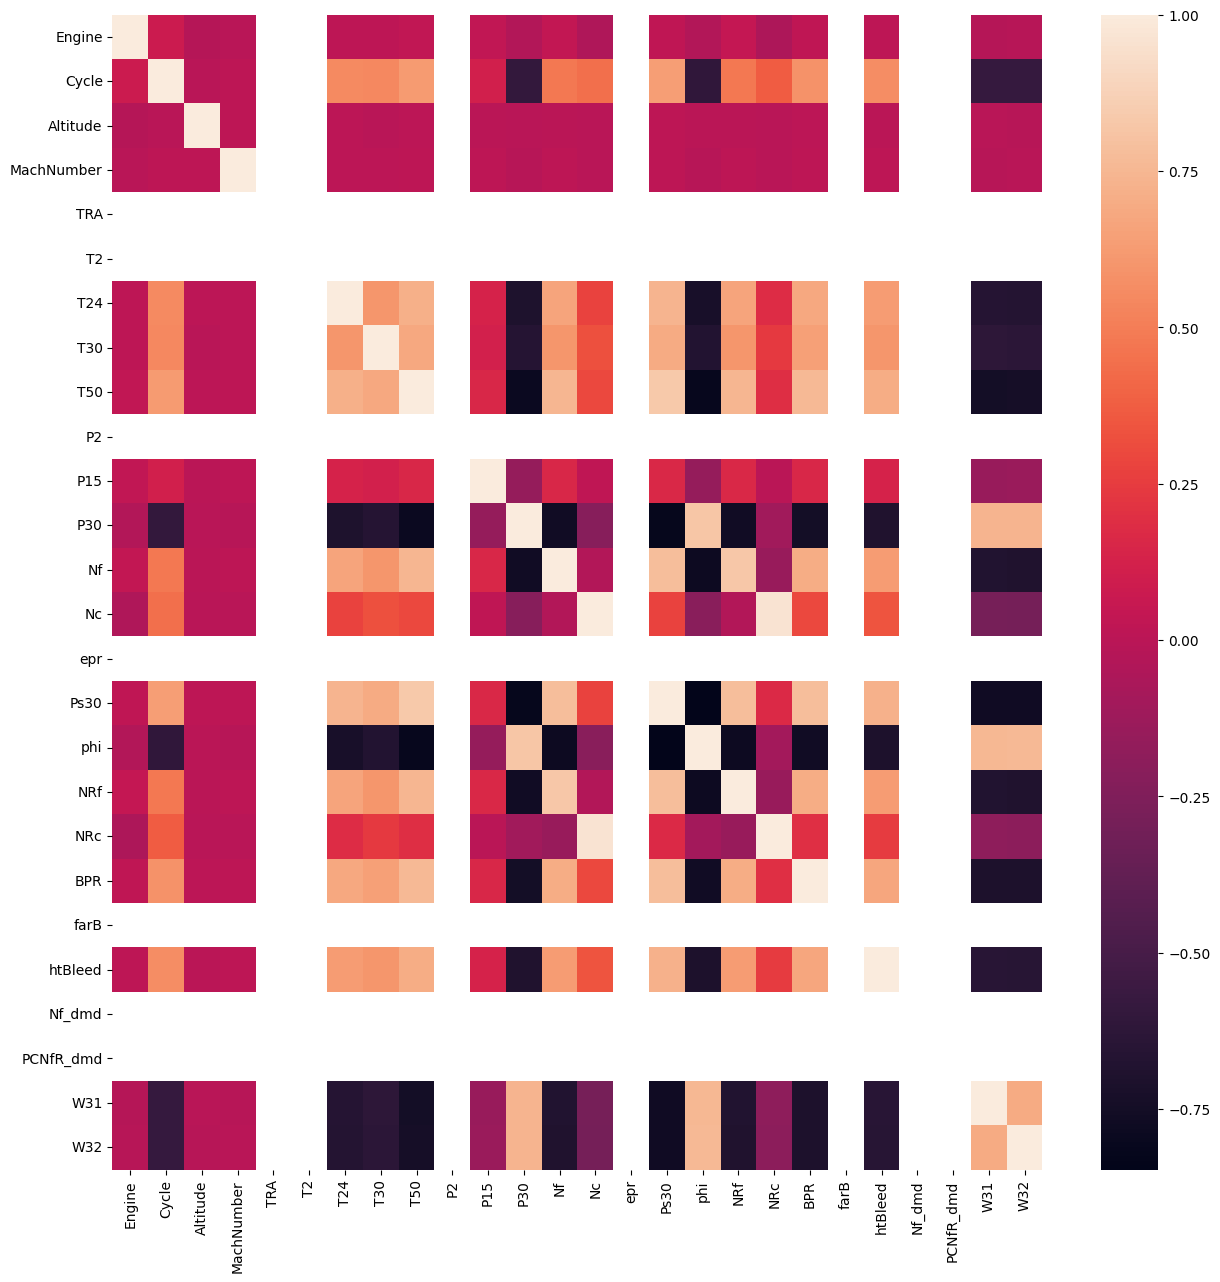

In [36]:
plt.figure(figsize=[15,15])
sns.heatmap(df_train.corr())

Why does some data have not had their correlations calculated? Let's take a look at them.

In [41]:
df_test[['TRA', 'T2', 'epr', 'farB', 'Nf_dmd', 'PCNfR_dmd']].describe()

,TRA,T2,epr,farB,Nf_dmd,PCNfR_dmd
count,13096.0,13096.00,1.309600e+04,1.309600e+04,13096.0,13096.0
mean,100.0,518.67,1.300000e+00,3.000000e-02,2388.0,100.0
std,0.0,0.00,2.220531e-16,1.040874e-17,0.0,0.0
min,100.0,518.67,1.300000e+00,3.000000e-02,2388.0,100.0
25%,100.0,518.67,1.300000e+00,3.000000e-02,2388.0,100.0
50%,100.0,518.67,1.300000e+00,3.000000e-02,2388.0,100.0
75%,100.0,518.67,1.300000e+00,3.000000e-02,2388.0,100.0
max,100.0,518.67,1.300000e+00,3.000000e-02,2388.0,100.0


Oh, they're constant.

### 3. Load the "RUL_FD001.txt" file. It contains the remaining useful lifetime of each engine in the test set at the end of the provided measurement period. Given this information, calculate the RUL for all provided data points in the test set and append your calculations to the test data.

,0,1
0,112,NaN
1,98,NaN
2,69,NaN
3,82,NaN
4,91,NaN


### 4. Create the label for the train and test data sets. An engine shall be classified as faulty (label = 1) if its RUL is below 30 and as healthy (label = 0) if it is above 30.

### 5. Construct the final data arrays for the machine learning model by extracting input features and output labels from the three datasets. As input features, you can use the available sensor data or a subset of it by excluding features with no variance (see Exercises 1 and 2). The output label is the label faulty/healthy that you have calculated in Question 4 of this exercise.

### 6. Split your training data into a training set and a validation set. Like that you have 3 datasets: a training, a validation and a test set. To do this, you can use the train_test_split function from scikit-learn library.

### 7. Train a decision tree classifier on the training data. Then, evaluate the performance of the classifier on the training and validation set. What can you conclude regarding possible overfitting or underfitting?

Useful python functions for this are:
- DecisionTreeClassifier from scikit-learn (https://scikit-learn.org/stable/modules/generated/sklearn.tree.DecisionTreeClassifier.html)
- Confusion_matrix and metrics like accuracy, precision, recall and f1-score from scikit-learn (https://scikit-learn.org/stable/modules/classes.html#module-sklearn.metrics)

### 8. The decision tree has several hyperparameters that affect the complexity of the built tree. One of them is the "max_depth" parameter. It defines the maximum depth of the tree, that means the maximum number of nodes (decisions) until the final classification is made. Try different values for this parameter to learn the decision tree. Plot the f1-score of the learned classifiers for training and validation set over the "max_depth" parameter. Can you define an optimal value for this parameter?

### 9. Use the optimal hyperparameter value to learn the final classifier. Evaluate your model on the test set.